# loading the data

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms.functional as F



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x),  # Invert the image
])

# Load the original EMNIST dataset with 3 channels
train_data = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)

# Create train-test split dataloaders
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"All classes: {test_data.classes}")
print(len(test_data.classes))
print(test_data.class_to_idx)


100%|██████████| 561753746/561753746 [00:06<00:00, 85650289.78it/s] 


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
All classes: ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27
{'N/A': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


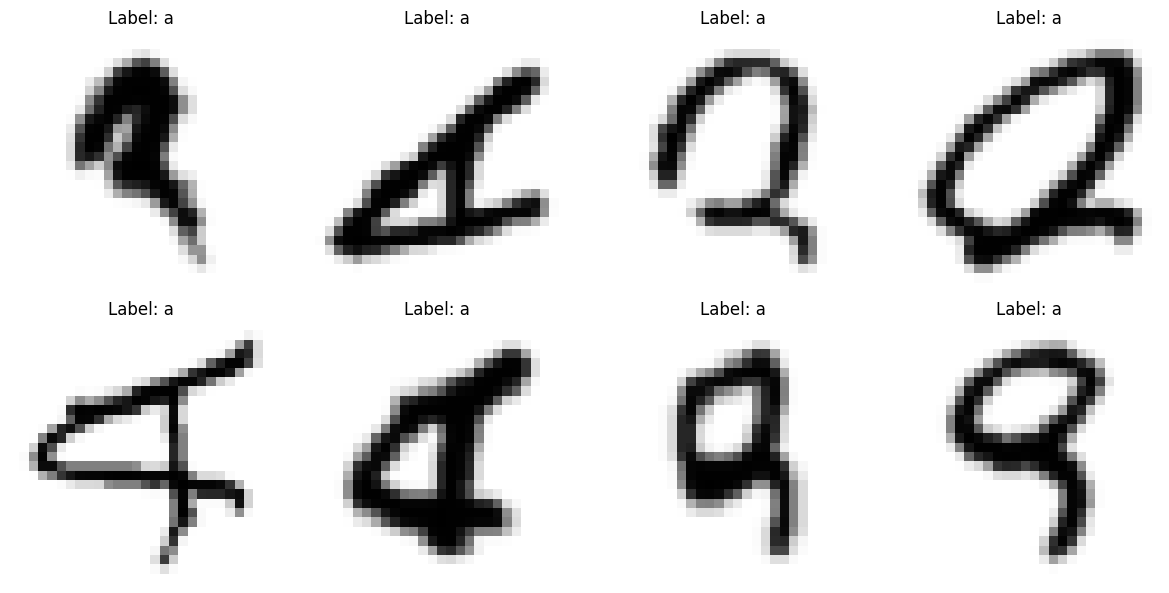

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Create DataLoader for the test data
view_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# Get the first batch of images and labels
data_iter = iter(view_loader)
images, labels = next(data_iter)



# Convert the images to numpy for plotting
images = images.numpy()

# Normalize images to the range [0, 1] for display
images = np.clip(images, 0, 1)  # Clip values to the range [0, 1] for display

# Plot the images in a 2x4 grid
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()  # Flatten the axes array for easy iteration

# Display each image with its label
for i in np.arange(8):
    ax = axes[i]
    ax.imshow(np.squeeze(images[i].transpose(1, 2, 0)), cmap='gray')
    ax.set_title(f'Label: {test_data.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


# model


In [4]:
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=27):
        super(AdvancedCNN, self).__init__()
        
        # First Convolution Block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input: 1 channel (grayscale), Output: 32 channels
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for stable learning
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: 64 channels
        self.bn2 = nn.BatchNorm2d(64)
        
        # Second Convolution Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: 128 channels
        self.bn3 = nn.BatchNorm2d(128)
        
        # Max Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)  # Pooling with 2x2 kernel to downsample
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)  # 50% dropout to avoid overfitting
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  # Input size after 3x3 convolutions and pooling
        self.fc2 = nn.Linear(512, num_classes)  # Output layer with 'num_classes' neurons
        
    def forward(self, x):
        # Convolution + Batch Norm + ReLU + Max Pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 1st conv block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 2nd conv block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 3rd conv block
        
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 128 * 3 * 3)  # Flattening the 128 x 3 x 3 output to a vector
        
        # Fully Connected Layer + Dropout
        x = F.relu(self.fc1(x))  # FC1 with ReLU activation
        x = self.dropout(x)  # Apply dropout for regularization
        x = self.fc2(x)  # Final output layer
        
        return x

# Initialize the model with 27 classes (EMNIST Letters)
model = AdvancedCNN(num_classes=27)
# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
criterion = nn.CrossEntropyLoss()


# Training

In [5]:
def norm_confusion_matrix(cm):
    row_sums= cm.sum(axis=1)
    norm_cm= cm/ row_sums[:, np.newaxis]
    return norm_cm

In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score ,confusion_matrix
from tqdm import tqdm
# Lists to hold metrics for each epoch
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []
f1_scores = []
precisions = []
recalls = []

# Updated train function
def train(model, train_loader, criterion, optimizer, device, epoch, num_epochs):
    global epoch_loss, epoch_accuracy 
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as tepoch:
        for images, labels in tepoch:
            # Move data to GPU
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Get the predicted class and calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            tepoch.set_postfix(loss=running_loss / (len(tepoch)), accuracy=100 * correct / total)

    # Calculate loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    # Store loss and accuracy for plotting later
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Updated evaluate function
def evaluate(model, test_loader, criterion, device):
    global test_accuracy, test_loss, f1, precision, recall ,cm , y_pred ,y_true 
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    y_pred = []
    y_true = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        with tqdm(test_loader, desc="Evaluating", unit="batch") as tepoch:
            for images, labels in tepoch:
                # Move data to GPU
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Update running loss
                running_loss += loss.item()

                # Get the predicted class and calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update progress bar
                tepoch.set_postfix(loss=running_loss / (len(tepoch)), accuracy=100 * correct / total)

                # Append predicted and true labels for metric calculation
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

    # Calculate loss and accuracy for the evaluation
    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    # Calculate F1, precision, and recall
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    cm = norm_confusion_matrix(cm)
    


    # Store evaluation metrics for plotting
    val_losses.append(test_loss)
    val_accuracies.append(test_accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
    print(f"F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    return test_loss, test_accuracy

In [7]:
num_epochs = 5
for epoch in range(num_epochs):
    # Pass num_epochs to the train function
    train(model, train_loader, criterion, optimizer, device, epoch, num_epochs)
    evaluate(model, test_loader, criterion, device)


Epoch 1/5: 100%|██████████| 975/975 [00:21<00:00, 45.26batch/s, accuracy=86.4, loss=0.428]


Epoch 1 - Loss: 0.4281, Accuracy: 86.38%


Evaluating: 100%|██████████| 163/163 [00:02<00:00, 58.40batch/s, accuracy=92.8, loss=0.215]


Test - Loss: 0.2152, Accuracy: 92.75%
F1-score: 0.9271, Precision: 0.9296, Recall: 0.9275


Epoch 2/5: 100%|██████████| 975/975 [00:19<00:00, 48.81batch/s, accuracy=92.4, loss=0.229] 


Epoch 2 - Loss: 0.2295, Accuracy: 92.39%


Evaluating: 100%|██████████| 163/163 [00:02<00:00, 59.21batch/s, accuracy=94, loss=0.177]  


Test - Loss: 0.1769, Accuracy: 93.96%
F1-score: 0.9393, Precision: 0.9401, Recall: 0.9396


Epoch 3/5: 100%|██████████| 975/975 [00:20<00:00, 48.45batch/s, accuracy=93.3, loss=0.196] 


Epoch 3 - Loss: 0.1964, Accuracy: 93.25%


Evaluating: 100%|██████████| 163/163 [00:02<00:00, 57.61batch/s, accuracy=94.3, loss=0.166]


Test - Loss: 0.1662, Accuracy: 94.34%
F1-score: 0.9434, Precision: 0.9445, Recall: 0.9434


Epoch 4/5: 100%|██████████| 975/975 [00:20<00:00, 47.34batch/s, accuracy=93.8, loss=0.179] 


Epoch 4 - Loss: 0.1788, Accuracy: 93.80%


Evaluating: 100%|██████████| 163/163 [00:02<00:00, 58.60batch/s, accuracy=93.9, loss=0.171]


Test - Loss: 0.1712, Accuracy: 93.89%
F1-score: 0.9384, Precision: 0.9417, Recall: 0.9389


Epoch 5/5: 100%|██████████| 975/975 [00:20<00:00, 47.97batch/s, accuracy=94.3, loss=0.163] 


Epoch 5 - Loss: 0.1628, Accuracy: 94.35%


Evaluating: 100%|██████████| 163/163 [00:02<00:00, 58.88batch/s, accuracy=94.6, loss=0.163]


Test - Loss: 0.1628, Accuracy: 94.56%
F1-score: 0.9457, Precision: 0.9464, Recall: 0.9456


# save the model to ONNX

In [10]:
import torch.onnx
from torch import nn

# Function to save the model in ONNX format
def save_model_to_onnx(model, file_path, input_sample):
    model.eval()  # Set the model to evaluation mode
    # Export the model to ONNX
    torch.onnx.export(model,  # Model to export
                      input_sample,  # Sample input for tracing
                      file_path,  # Path where the model will be saved
                      export_params=True,  # Store trained parameters
                      opset_version=12,  # Specify the ONNX opset version
                      do_constant_folding=True,  # Optimization for constant folding
                      input_names=["input"],  # Name of the input layer
                      output_names=["output"],  # Name of the output layer
                      dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}})  # Allow variable batch sizes

    print(f"Model saved to {file_path}")

dummy_input = torch.randn(1,1, 28, 28).to(device)  # Grayscale image

# Define the path to save the ONNX model
onnx_file_path = "emnist.onnx"

# Save the model in ONNX format
save_model_to_onnx(model, onnx_file_path, dummy_input)


Model saved to emnist.onnx


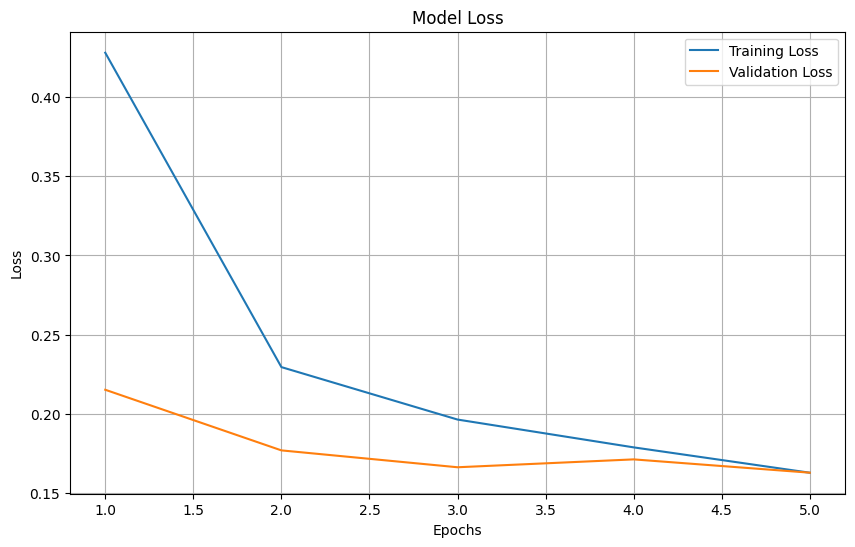

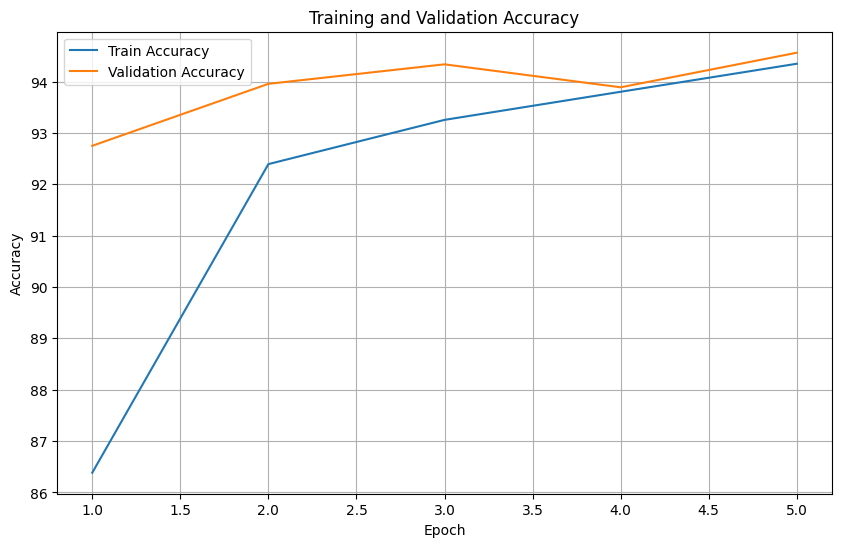

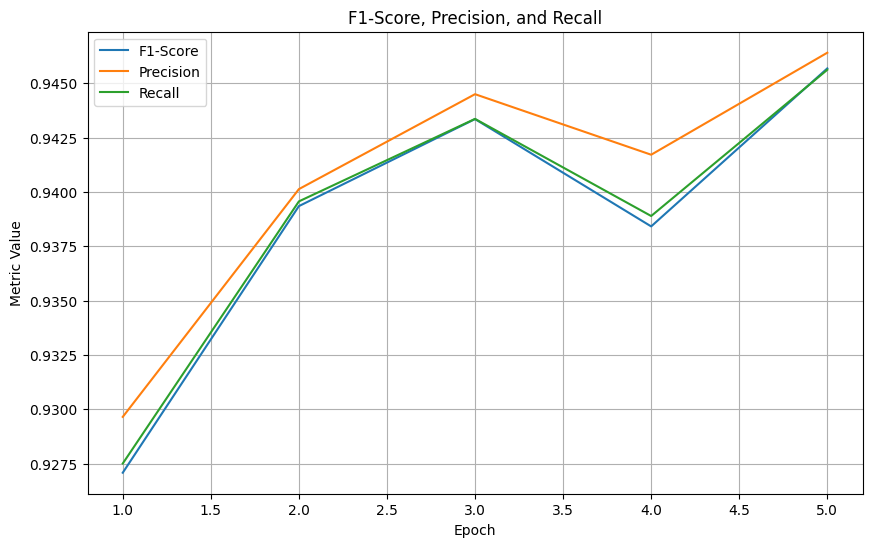

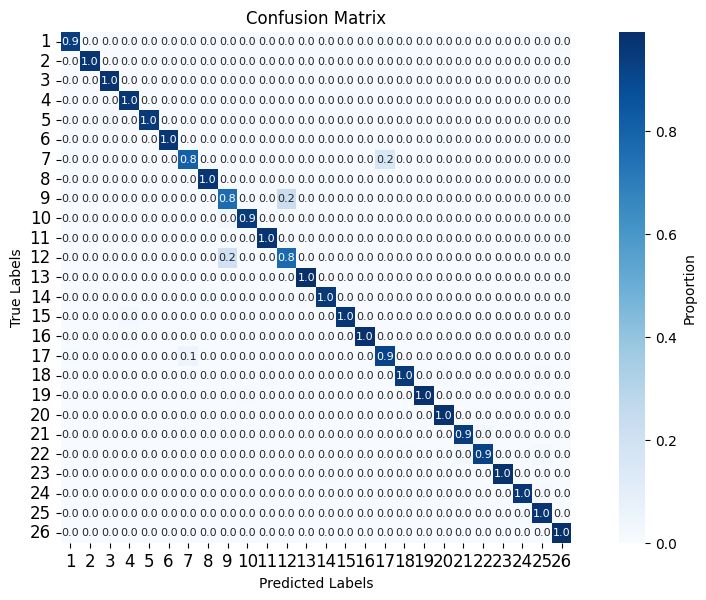

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=1, suppress=True)
# Number of epochs
epochs = range(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1-score, precision, and recall (assuming you have lists of these metrics)
plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_scores, label='F1-Score')
plt.plot(epochs, precisions, label='Precision')
plt.plot(epochs, recalls, label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('F1-Score, Precision, and Recall')
plt.legend()
plt.grid(True)
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='.1f', cmap="Blues", square=True,  xticklabels=range(1, len(cm) +1), yticklabels=range(1, len(cm) +1), annot_kws={'size':8},
           cbar_kws={'label': 'Proportion'})

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout(pad=1.5)
plt.title("Confusion Matrix")
plt.show()